# NN vs QNN

In [1]:
!pip install tensorflow

In [2]:
!pip install qiskit==0.44.1 qiskit-aer==0.13.1 qiskit-machine-learning==0.6.1
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542100 sha256=762c9f2c745535cf8770bc161bbaf39e54b3199234df93d7362abda81f05d2d6
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

Dataset de la parte de un Dataset preprocesado con cerca de 2 millones de datos. Cronológicamente, estos corresponden a los últimos meses de los que se tienen registros.

## Preparación de los datos

In [3]:
import pandas as pd

data = pd.read_csv("data.csv")

data.head()

,category,amt,state,lat,long,is_fraud,hora,dia,mes,edad,card_type,previous_fraud_client,previous_fraud_merchant,gender_M,periodo_dia_noche,periodo_dia_tarde
0,0.002404,91.82,0.005391,41.6060,-109.2300,0,12,5,8,36,0.005559,1.0,1.0,False,False,False
1,0.001621,38.60,0.005991,37.0581,-86.1938,0,12,5,8,21,0.005652,1.0,1.0,False,False,False
2,0.013720,104.39,0.006025,44.8232,-89.1665,0,7,5,8,66,0.005652,1.0,1.0,True,False,False
3,0.013989,3.68,0.005193,46.5901,-117.1692,0,10,5,8,77,0.005652,1.0,1.0,False,False,False
4,0.013989,1.61,0.006197,42.1939,-76.7361,0,8,5,8,29,0.004766,1.0,1.0,False,False,False


Seleccionamos solo las columnas de mayor interés.

In [4]:
data_2 = data.drop(['state', 'lat', 'long', 'hora', 'dia', 'mes', 'gender_M', 'periodo_dia_tarde'], axis=1)

data_2.columns

Index(['category', 'amt', 'is_fraud', 'edad', 'card_type',
       'previous_fraud_client', 'previous_fraud_merchant',
       'periodo_dia_noche'],
      dtype='object')

Como vemos tenemos muchos datos y están altamente desbalanceados, creamos 3 datasets más sencillos.

In [5]:
data_2.is_fraud.value_counts()

,count
is_fraud,
0,398565
1,1452


In [6]:
import pandas as pd

def crear_submuestra_balanceada(df, label_col, total_muestra, proporcion_clase_mayor=0.75):
    # Contar clases
    clases = df['is_fraud'].unique()
    if len(clases) != 2:
        raise ValueError("Este método está pensado para problemas binarios (dos clases).")

    # Determinar cuántas instancias tomar de cada clase
    n_mayor = int(total_muestra * proporcion_clase_mayor)
    n_menor = total_muestra - n_mayor

    # Detectar qué clase es la mayor
    conteos = df['is_fraud'].value_counts()
    clase_mayor = conteos.idxmax()
    clase_menor = conteos.idxmin()

    # Tomar muestras aleatorias
    df_mayor = df[df['is_fraud'] == clase_mayor].sample(n=n_mayor, random_state=42)
    df_menor = df[df['is_fraud'] == clase_menor].sample(n=n_menor, random_state=42)

    # Combinar y mezclar
    df_final = pd.concat([df_mayor, df_menor]).sample(frac=1, random_state=42).reset_index(drop=True)
    return df_final

# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500)

Vamos a comparar cuatro pares de algoritmos clásicos con sus contrapartidas cuánticas sobre los dos df reducidos de arriba para ver qué algortimos captan mejor las características de los datos, evaluando los resultados en tareas de clasificación y teniendo en cuanta tiempos de entrenamiento e inferencia aproximados. Se realizarán las siguientes comparativas:

- NN clásica vs QNN

- SVM clásica vs Quantum SVM

- KNN vs QKNN

- Regresión Logística vs VQC

- PCA vs QPCA con Decision Tree y VQC

En este primer Notebook se realiza la primera de las comparaciones mencionadas.

## Estudio comparativo (Desbalanceo 75-25)

### 200 datos

Separación en conjuntos de train y test.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Asumimos que la columna 'label' es el target
x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### NN

In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

model = Sequential([
    Dense(16, activation='relu', input_shape=(x_train_1.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train_1, y_train_1, epochs=30, batch_size=16, verbose=1)

Epoch 1/30
9/9 [==============================] - 5s 8ms/step - loss: 2.1347 - accuracy: 0.5143
Epoch 2/30
9/9 [==============================] - 0s 6ms/step - loss: 1.6831 - accuracy: 0.5857
Epoch 3/30
9/9 [==============================] - 0s 6ms/step - loss: 1.3461 - accuracy: 0.6214
Epoch 4/30
9/9 [==============================] - 0s 9ms/step - loss: 1.0459 - accuracy: 0.6357
Epoch 5/30
9/9 [==============================] - 0s 15ms/step - loss: 0.8271 - accuracy: 0.6571
Epoch 6/30
9/9 [==============================] - 0s 11ms/step - loss: 0.7159 - accuracy: 0.7071
Epoch 7/30
9/9 [==============================] - 0s 10ms/step - loss: 0.6326 - accuracy: 0.8000
Epoch 8/30
9/9 [==============================] - 0s 7ms/step - loss: 0.5929 - accuracy: 0.8714
Epoch 9/30
9/9 [==============================] - 0s 8ms/step - loss: 0.5722 - accuracy: 0.8714
Epoch 10/30
9/9 [==============================] - 0s 12ms/step - loss: 0.5727 - accuracy: 0.8643
Epoch 11/30
9/9 [==================

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

y_pred_1 = model.predict(x_test_1)

acc_nn_1 = accuracy_score(y_test_1, y_pred_1.round())
f1_nn_1 = f1_score(y_test_1, y_pred_1.round())
print("Accuracy:", acc_nn_1)
print("F1 Score:", f1_nn_1)

2/2 [==============================] - 1s 7ms/step
Accuracy: 0.8833333333333333
F1 Score: 0.7407407407407408


Tiempos de entrenamiento/inferencia: Inmediatos

#### QNN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from sklearn.preprocessing import MinMaxScaler

algorithm_globals.random_seed = 42

# Escalar entre 0 y 1 para usar ZZFeatureMap.
scaler = MinMaxScaler()
x_train_1_scaled = scaler.fit_transform(x_train_1)
x_test_1_scaled = scaler.transform(x_test_1)

# Transformamos los datos al formato adecuado para Torch.
x_train_tensor_1 = torch.tensor(x_train_1_scaled, dtype=torch.float32)
y_train_tensor_1 = torch.tensor(y_train_1, dtype=torch.float32)

# Creamos DataLoader de entrenamiento a partir de lo anterior.
train_dataset_1 = TensorDataset(x_train_tensor_1, y_train_tensor_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size=4, shuffle=True)

Codificamos nuestros datos en el circuito cuántico mediante un ZZFeatureMap.

In [ ]:
num_qubits = x_train_1.shape[1]

# Definimos las partes del circuito cuántico.
feature_map =ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

# Creamos el circuito cuántico.
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Vamos a medir Z en el último qubit.
observable = SparsePauliOp.from_list([("Z" + "I"*(num_qubits-1), 1)])

# Creamos el estimator.
estimator = Estimator()

# Creamos el circuito cuántico.
qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True
)

In [ ]:
# Convertimos a Torch.
qnn_torch = TorchConnector(qnn)

In [ ]:
# Creamos un modelo híbrido gracias a PyTorch.
class CustomQNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.qnn = qnn_torch

  def forward(self, x):
    return self.qnn(x)

In [ ]:
# Preparamos la red.
model_qnn = CustomQNN()
optimizer = torch.optim.Adam(model_qnn.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# Se lleva a cabo el entrenamiento.
for epoch in range(20):
    print(f"Época {epoch}")
    for xb, yb in train_loader_1:
        optimizer.zero_grad()
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2
        loss = loss_fn(output, yb)
        loss.backward()
        optimizer.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Tiempo de entrenamiento: 1h 45min.

In [ ]:
# Guardamos el modelo cuántico.
torch.save(model_qnn.state_dict(), "custom_qnn_200.pth")

In [ ]:
# Cargamos el modelo.
model_qnn.load_state_dict(torch.load("custom_qnn_200.pth"))
model_qnn.eval()

CustomQNN(
  (qnn): TorchConnector()
)

Realizamos las predicciones.

In [ ]:
test_dataset = TensorDataset(torch.tensor(x_test_1_scaled).float(), torch.tensor(y_test_1).float())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Función de pérdida y variables de evaluación.
loss_fn = torch.nn.BCELoss()
total_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2

        # Acumulamos pérdida.
        loss = loss_fn(output, yb)
        total_loss += loss.item()

        # Clasificación binaria con umbral
        predictions = (output >= 0.53).float()

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Métricas sklearn
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
avg_loss = total_loss / len(test_loader)

# Resultados
print("\nEvaluación del modelo:")
print(f" - Accuracy:  {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall:    {recall:.4f}")
print(f" - F1 Score:  {f1:.4f}")
print(f" - Loss promedio: {avg_loss:.4f}")
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, zero_division=0))


Evaluación del modelo:
 - Accuracy: 0.5500
 - F1 Score: 0.3194
 - Loss promedio: 0.7221


### 500 datos

Separación en conjuntos de train y test.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Asumimos que la columna 'label' es el target
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### NN

In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

model = Sequential([
    Dense(16, activation='relu', input_shape=(x_train_1.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(x_train_1, y_train_1, epochs=30, batch_size=16, verbose=1)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8132 - loss: 1.7917
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8647 - loss: 0.4640
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9021 - loss: 0.3274
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8793 - loss: 0.3964
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8831 - loss: 0.3521
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8955 - loss: 0.3462
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9125 - loss: 0.3114
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9018 - loss: 0.3102
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9161 - loss: 0.2861
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8729 - loss: 0.3411
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8986 - loss: 0.3599
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9036 - lo

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

y_pred_1 = model.predict(x_test_1)

acc_nn_1 = accuracy_score(y_test_1, y_pred_1.round())
f1_nn_1 = f1_score(y_test_1, y_pred_1.round())
print("Accuracy:", acc_nn_1)
print("F1 Score:", f1_nn_1)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 0.88
F1 Score: 0.7352941176470589


Tiempos de entrenamiento/inferencia: Inmediatos

#### QNN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from sklearn.preprocessing import MinMaxScaler

algorithm_globals.random_seed = 42

# Escalar entre 0 y 1 para usar ZZFeatureMap.
scaler = MinMaxScaler()
x_train_1_scaled = scaler.fit_transform(x_train_1)
x_test_1_scaled = scaler.transform(x_test_1)

# Transformamos los datos al formato adecuado para Torch.
x_train_tensor_1 = torch.tensor(x_train_1_scaled, dtype=torch.float32)
y_train_tensor_1 = torch.tensor(y_train_1, dtype=torch.float32)

# Creamos DataLoader de entrenamiento a partir de lo anterior.
train_dataset_1 = TensorDataset(x_train_tensor_1, y_train_tensor_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size=4, shuffle=True)

Codificamos nuestros datos en el circuito cuántico mediante un ZZFeatureMap.

In [ ]:
num_qubits = x_train_1.shape[1]

# Definimos las partes del circuito cuántico.
feature_map =ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

# Creamos el circuito cuántico.
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Vamos a medir Z en el último qubit.
observable = SparsePauliOp.from_list([("Z" + "I"*(num_qubits-1), 1)])

# Creamos el estimator.
estimator = Estimator()

# Creamos el circuito cuántico.
qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True
)

In [ ]:
# Convertimos a Torch.
qnn_torch = TorchConnector(qnn)

In [ ]:
# Creamos un modelo híbrido gracias a PyTorch.
class CustomQNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.qnn = qnn_torch

  def forward(self, x):
    return self.qnn(x)

In [ ]:
# Preparamos la red.
model_qnn = CustomQNN()
optimizer = torch.optim.Adam(model_qnn.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# Se lleva a cabo el entrenamiento.
for epoch in range(20):
    print(f"Época {epoch}")
    for xb, yb in train_loader_1:
        optimizer.zero_grad()
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2
        loss = loss_fn(output, yb)
        loss.backward()
        optimizer.step()

Época 0
Época 1
Época 2
Época 3
Época 4
Época 5
Época 6
Época 7
Época 8
Época 9
Época 10
Época 11
Época 12
Época 13
Época 14
Época 15
Época 16
Época 17
Época 18
Época 19


Tiempo de entrenamiento: 1h 45min.

In [ ]:
# Guardamos el modelo cuántico.
torch.save(model_qnn.state_dict(), "custom_qnn_500.pth")

In [ ]:
# Cargamos el modelo.
model_qnn.load_state_dict(torch.load("custom_qnn_500.pth"))
model_qnn.eval()

CustomQNN(
  (qnn): TorchConnector()
)

Realizamos las predicciones.

In [ ]:
test_dataset = TensorDataset(torch.tensor(x_test_1_scaled).float(), torch.tensor(y_test_1).float())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Función de pérdida y variables de evaluación.
loss_fn = torch.nn.BCELoss()
total_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2

        # Acumulamos pérdida.
        loss = loss_fn(output, yb)
        total_loss += loss.item()

        # Clasificación binaria con umbral
        predictions = (output >= 0.53).float()

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Métricas sklearn
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
avg_loss = total_loss / len(test_loader)

# Resultados
print("\nEvaluación del modelo:")
print(f" - Accuracy:  {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall:    {recall:.4f}")
print(f" - F1 Score:  {f1:.4f}")
print(f" - Loss promedio: {avg_loss:.4f}")
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, zero_division=0))


Evaluación del modelo:
 - Accuracy:  0.7333
 - Precision: 0.2000
 - Recall:    0.0270
 - F1 Score:  0.0476
 - Loss promedio: 0.6982

Reporte de clasificación:

              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84       113
         1.0       0.20      0.03      0.05        37

    accuracy                           0.73       150
   macro avg       0.48      0.50      0.45       150
weighted avg       0.62      0.73      0.65       150



## Estudio Comparativo (Sin Desbalanceo)

In [ ]:
# Crear muestras
df1 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=200, proporcion_clase_mayor=0.5)
df2 = crear_submuestra_balanceada(data_2, label_col='label', total_muestra=500, proporcion_clase_mayor=0.5)

### 200 datos

Separación en conjuntos de train y test.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Asumimos que la columna 'label' es el target
x1 = df1.drop(columns='is_fraud')
y1 = df1['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### NN

In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

model = Sequential([
    Dense(16, activation='relu', input_shape=(x_train_1.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(x_train_1, y_train_1, epochs=30, batch_size=16, verbose=1)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5662 - loss: 4.4512
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5198 - loss: 5.2691  
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6460 - loss: 2.6188  
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6841 - loss: 2.1008 
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7127 - loss: 1.5366 
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7935 - loss: 1.2982  
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8493 - loss: 0.8071 
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8329 - loss: 0.5888  
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8700 - loss: 0.4090  
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8581 - loss: 0.5175 
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8471 - loss: 0.5429  
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8809 - loss: 0.37

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

y_pred_1 = model.predict(x_test_1)

acc_nn_1 = accuracy_score(y_test_1, y_pred_1.round())
f1_nn_1 = f1_score(y_test_1, y_pred_1.round())
print("Accuracy:", acc_nn_1)
print("F1 Score:", f1_nn_1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Accuracy: 0.8166666666666667
F1 Score: 0.8


Tiempos de entrenamiento/inferencia: Inmediatos

#### QNN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from sklearn.preprocessing import MinMaxScaler

algorithm_globals.random_seed = 42

# Escalar entre 0 y 1 para usar ZZFeatureMap.
scaler = MinMaxScaler()
x_train_1_scaled = scaler.fit_transform(x_train_1)
x_test_1_scaled = scaler.transform(x_test_1)

# Transformamos los datos al formato adecuado para Torch.
x_train_tensor_1 = torch.tensor(x_train_1_scaled, dtype=torch.float32)
y_train_tensor_1 = torch.tensor(y_train_1, dtype=torch.float32)

# Creamos DataLoader de entrenamiento a partir de lo anterior.
train_dataset_1 = TensorDataset(x_train_tensor_1, y_train_tensor_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size=4, shuffle=True)

Codificamos nuestros datos en el circuito cuántico mediante un ZZFeatureMap.

In [ ]:
num_qubits = x_train_1.shape[1]

# Definimos las partes del circuito cuántico.
feature_map =ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

# Creamos el circuito cuántico.
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Vamos a medir Z en el último qubit.
observable = SparsePauliOp.from_list([("Z" + "I"*(num_qubits-1), 1)])

# Creamos el estimator.
estimator = Estimator()

# Creamos el circuito cuántico.
qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True
)

In [ ]:
# Convertimos a Torch.
qnn_torch = TorchConnector(qnn)

In [ ]:
# Creamos un modelo híbrido gracias a PyTorch.
class CustomQNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.qnn = qnn_torch

  def forward(self, x):
    return self.qnn(x)

In [ ]:
# Preparamos la red.
model_qnn = CustomQNN()
optimizer = torch.optim.Adam(model_qnn.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# Se lleva a cabo el entrenamiento.
for epoch in range(20):
    print(f"Época {epoch}")
    for xb, yb in train_loader_1:
        optimizer.zero_grad()
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2
        loss = loss_fn(output, yb)
        loss.backward()
        optimizer.step()

Época 0
Época 1
Época 2
Época 3
Época 4
Época 5
Época 6
Época 7
Época 8
Época 9
Época 10
Época 11
Época 12
Época 13
Época 14
Época 15
Época 16
Época 17
Época 18
Época 19


Tiempo de entrenamiento: 1h 45min.

In [ ]:
# Guardamos el modelo cuántico.
torch.save(model_qnn.state_dict(), "no_imbalance_qnn_200.pth")

In [ ]:
# Cargamos el modelo.
model_qnn.load_state_dict(torch.load("no_imbalance_qnn_200.pth"))
model_qnn.eval()

CustomQNN(
  (qnn): TorchConnector()
)

Realizamos las predicciones.

In [ ]:
test_dataset = TensorDataset(torch.tensor(x_test_1_scaled).float(), torch.tensor(y_test_1).float())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Función de pérdida y variables de evaluación.
loss_fn = torch.nn.BCELoss()
total_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2

        # Acumulamos pérdida.
        loss = loss_fn(output, yb)
        total_loss += loss.item()

        # Clasificación binaria con umbral
        predictions = (output >= 0.53).float()

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Métricas sklearn
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
avg_loss = total_loss / len(test_loader)

# Resultados
print("\nEvaluación del modelo:")
print(f" - Accuracy:  {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall:    {recall:.4f}")
print(f" - F1 Score:  {f1:.4f}")
print(f" - Loss promedio: {avg_loss:.4f}")
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, zero_division=0))


Evaluación del modelo:
 - Accuracy:  0.7667
 - Precision: 0.7222
 - Recall:    0.8667
 - F1 Score:  0.7879
 - Loss promedio: 0.6179

Reporte de clasificación:

              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74        30
         1.0       0.72      0.87      0.79        30

    accuracy                           0.77        60
   macro avg       0.78      0.77      0.76        60
weighted avg       0.78      0.77      0.76        60



### 500 datos

Separación en conjuntos de train y test.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Asumimos que la columna 'label' es el target
x1 = df2.drop(columns='is_fraud')
y1 = df2['is_fraud']

x1 = np.array(x1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(
    x1, y1, test_size=0.3, stratify=y1, random_state=42
)

#### NN

In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

model = Sequential([
    Dense(16, activation='relu', input_shape=(x_train_1.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.fit(x_train_1, y_train_1, epochs=30, batch_size=16, verbose=1)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4936 - loss: 5.0254
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5290 - loss: 2.2297
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7984 - loss: 0.6048
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8466 - loss: 0.4345
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8154 - loss: 0.4910
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8309 - loss: 0.4772
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8206 - loss: 0.4405
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8310 - loss: 0.4194
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8310 - loss: 0.4752
Epoch 10/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8025 - loss: 0.4395
Epoch 11/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8227 - loss: 0.4083
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8384 - lo

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

y_pred_1 = model.predict(x_test_1)

acc_nn_1 = accuracy_score(y_test_1, y_pred_1.round())
f1_nn_1 = f1_score(y_test_1, y_pred_1.round())
print("Accuracy:", acc_nn_1)
print("F1 Score:", f1_nn_1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.8466666666666667
F1 Score: 0.8391608391608392


Tiempos de entrenamiento/inferencia: Inmediatos

#### QNN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import algorithm_globals
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from sklearn.preprocessing import MinMaxScaler

algorithm_globals.random_seed = 42

# Escalar entre 0 y 1 para usar ZZFeatureMap.
scaler = MinMaxScaler()
x_train_1_scaled = scaler.fit_transform(x_train_1)
x_test_1_scaled = scaler.transform(x_test_1)

# Transformamos los datos al formato adecuado para Torch.
x_train_tensor_1 = torch.tensor(x_train_1_scaled, dtype=torch.float32)
y_train_tensor_1 = torch.tensor(y_train_1, dtype=torch.float32)

# Creamos DataLoader de entrenamiento a partir de lo anterior.
train_dataset_1 = TensorDataset(x_train_tensor_1, y_train_tensor_1)
train_loader_1 = DataLoader(train_dataset_1, batch_size=4, shuffle=True)

Codificamos nuestros datos en el circuito cuántico mediante un ZZFeatureMap.

In [ ]:
num_qubits = x_train_1.shape[1]

# Definimos las partes del circuito cuántico.
feature_map =ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

# Creamos el circuito cuántico.
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Vamos a medir Z en el último qubit.
observable = SparsePauliOp.from_list([("Z" + "I"*(num_qubits-1), 1)])

# Creamos el estimator.
estimator = Estimator()

# Creamos el circuito cuántico.
qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True
)

In [ ]:
# Convertimos a Torch.
qnn_torch = TorchConnector(qnn)

In [ ]:
# Creamos un modelo híbrido gracias a PyTorch.
class CustomQNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.qnn = qnn_torch

  def forward(self, x):
    return self.qnn(x)

In [ ]:
# Preparamos la red.
model_qnn = CustomQNN()
optimizer = torch.optim.Adam(model_qnn.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# Se lleva a cabo el entrenamiento.
for epoch in range(20):
    print(f"Época {epoch}")
    for xb, yb in train_loader_1:
        optimizer.zero_grad()
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2
        loss = loss_fn(output, yb)
        loss.backward()
        optimizer.step()

Época 0
Época 1
Época 2
Época 3
Época 4
Época 5
Época 6
Época 7
Época 8
Época 9
Época 10
Época 11
Época 12
Época 13
Época 14
Época 15
Época 16
Época 17
Época 18
Época 19


Tiempo de entrenamiento: 3h 45min.

In [ ]:
# Guardamos el modelo cuántico.
torch.save(model_qnn.state_dict(), "no_imbalance_qnn_500.pth")

In [ ]:
# Cargamos el modelo.
model_qnn.load_state_dict(torch.load("no_imbalance_qnn_500.pth"))
model_qnn.eval()

CustomQNN(
  (qnn): TorchConnector()
)

Realizamos las predicciones.

In [ ]:
test_dataset = TensorDataset(torch.tensor(x_test_1_scaled).float(), torch.tensor(y_test_1).float())
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Función de pérdida y variables de evaluación.
loss_fn = torch.nn.BCELoss()
total_loss = 0

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        raw_output = model_qnn(xb).squeeze()
        output = (raw_output + 1) / 2

        # Acumulamos pérdida.
        loss = loss_fn(output, yb)
        total_loss += loss.item()

        # Clasificación binaria con umbral
        predictions = (output >= 0.53).float()

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Métricas sklearn
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
avg_loss = total_loss / len(test_loader)

# Resultados
print("\nEvaluación del modelo:")
print(f" - Accuracy:  {accuracy:.4f}")
print(f" - Precision: {precision:.4f}")
print(f" - Recall:    {recall:.4f}")
print(f" - F1 Score:  {f1:.4f}")
print(f" - Loss promedio: {avg_loss:.4f}")
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, zero_division=0))


Evaluación del modelo:
 - Accuracy:  0.7600
 - Precision: 0.7097
 - Recall:    0.8800
 - F1 Score:  0.7857
 - Loss promedio: 0.6121

Reporte de clasificación:

              precision    recall  f1-score   support

         0.0       0.84      0.64      0.73        75
         1.0       0.71      0.88      0.79        75

    accuracy                           0.76       150
   macro avg       0.78      0.76      0.76       150
weighted avg       0.78      0.76      0.76       150



## Resultados

### Accuracy (Desbalanceado vs Balanceado)

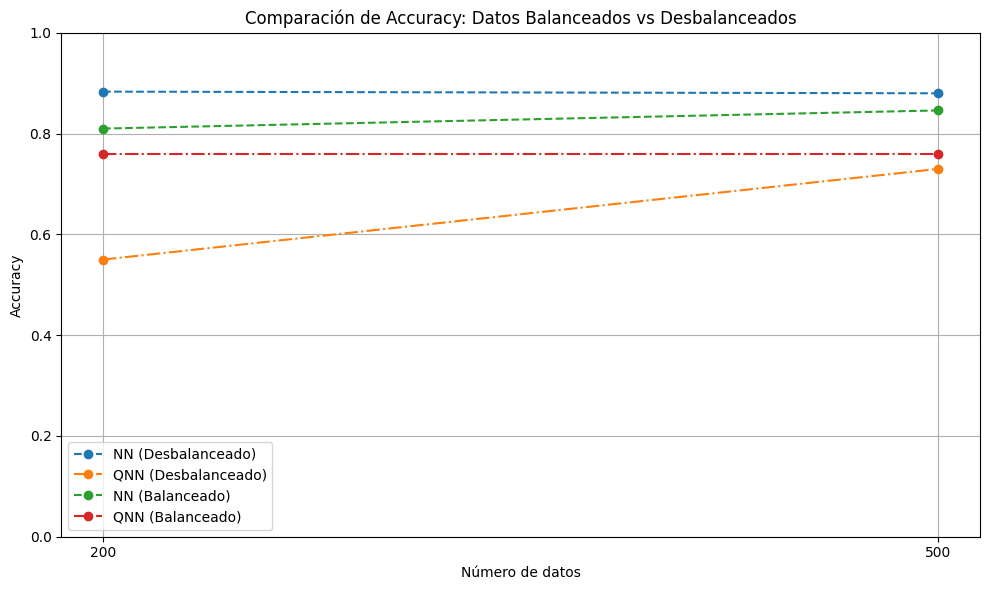

In [13]:
import matplotlib.pyplot as plt

# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
acc_nn_dblc = [0.88333, 0.88]
acc_qnn_dblc = [0.55, 0.73]
# Sin Desbalanceao
acc_nn_ndblc = [0.81, 0.846]
acc_qnn_ndblc = [0.76, 0.76]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, acc_nn_dblc, marker='o', linestyle='--', label='NN (Desbalanceado)')
plt.plot(num_datos, acc_qnn_dblc, marker='o', linestyle='-.', label='QNN (Desbalanceado)')
plt.plot(num_datos, acc_nn_ndblc, marker='o', linestyle='--', label='NN (Balanceado)')
plt.plot(num_datos, acc_qnn_ndblc, marker='o', linestyle='-.', label='QNN (Balanceado)')

# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy: Datos Balanceados vs Desbalanceados')
plt.xticks([200, 500])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### F1 Score (Desbalanceado vs Balanceado)

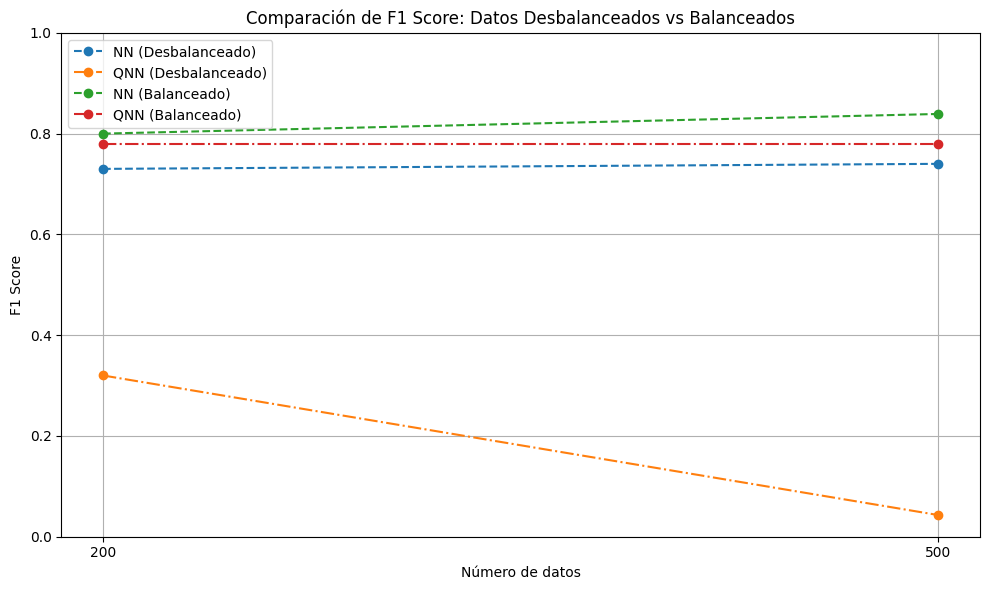

In [14]:
# Eje X: número de datos
num_datos = [200, 500]

# Desbalanceado
f1_nn_dblc = [0.73, 0.74]
f1_qnn_dblc = [0.32, 0.043]
# Sin Desbalanceo
f1_nn_ndblc = [0.8, 0.839]
f1_qnn_ndblc = [0.78, 0.78]

plt.figure(figsize=(10, 6))

# Graficamos cada curva
plt.plot(num_datos, f1_nn_dblc, marker='o', linestyle='--', label='NN (Desbalanceado)')
plt.plot(num_datos, f1_qnn_dblc, marker='o', linestyle='-.', label='QNN (Desbalanceado)')
plt.plot(num_datos, f1_nn_ndblc, marker='o', linestyle='--', label='NN (Balanceado)')
plt.plot(num_datos, f1_qnn_ndblc, marker='o', linestyle='-.', label='QNN (Balanceado)')
# Etiquetas y leyenda
plt.xlabel('Número de datos')
plt.ylabel('F1 Score')
plt.title('Comparación de F1 Score: Datos Desbalanceados vs Balanceados')
plt.xticks([200, 500])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()